# Tasks
____________________________

## Tasks Overview 
________________________

[Tasks](https://docs.descarteslabs.com/guides/tasks.html) provides a solution for large-scale computation within the Descartes Labs platform. Tasks can be used to train models, deploy algorithms over large regions of interest, or programmatically retrieve data from a sources such as Scenes. Tasks nodes only consume resources when used and autoscale up and down as needed. Tasks is best suited for highly parallel workflows where each unit of work is small in size.

The general terminology of Tasks is:

* **Tasks**: The interface to interact with the Tasks service. 
* **Task**: A single unit of work.
* **Task Group**: A collection of tasks running on a common environment and code base.
* **Async / Cloud Function**: An function object that submits jobs to the Task group.
* **Image**: Docker image that a task runs in.
* **Workers**: Number of CPUs / GPUs nodes in a Tasks group.

You can run the following cells using `Shift-Enter`.

### What's the difference between Tasks and Workflows? 
Our Tasks system lets you run standard python code on our infrastructure at scale. Workflows uses Descartes Labs provided methods to allow you to write reusable and shareable algorithms which we scale on our infrastructure for you. Workflows can be sequenced into larger Workflows allowing you to reuse existing algorithms for faster model development. The example below could be executed in Workflows, too, but would obscure some of the code from the user.

## Vegetation Percentage
__________________

Let's say we were interested in estimating the percentage of farmland that has crops. A simple metric that is indicative of vegetation is NDVI, the normalized difference between the *nir* and *red* bands.  

$$NDVI = \frac{N - R}{N + R}$$

An NDVI value above 0.3 generally indicates the presence of vegetation.

In [ ]:
# keep logging quiet
import logging
logging.getLogger().setLevel(logging.INFO)
logging.captureWarnings(True)

In [ ]:
# import packages
import descarteslabs as dl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

For this analysis we will use the NAIP dataset which contains high-resolution aerial imagery over the US.

In [ ]:
def get_image(dltile_key):
    tile = dl.scenes.DLTile.from_key(dltile_key)
    sc, ctx = dl.scenes.search(aoi=tile, products='usda:naip:rgbn:v1', start_datetime='2015-01-01', end_datetime='2016-01-01')
    im = sc.mosaic(bands='red green blue nir', ctx=ctx)
    return im

In [ ]:
def vegetation_mask(im):
    n = im[-1].astype(float)
    r = im[0].astype(float)
    NDVI = (n - r) / (n + r + 1e-8)
    return NDVI

Let's look at an example crop field over Nebraska.

In [ ]:
lon, lat = -99.35249805450438,39.38670997057946
tile = dl.scenes.DLTile.from_latlon(lat=lat, lon=lon, resolution=1, tilesize=256, pad=0)

In [ ]:
im = get_image(tile.key)
veg_mask = vegetation_mask(im)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].imshow(np.moveaxis(im[0:3], 0, -1))
ax[1].imshow(veg_mask > 0.3)
ax[2].imshow(np.moveaxis(im[0:3], 0, -1))
ax[2].imshow(veg_mask > 0.3, alpha=0.3, clim=(0, 1))
ax[0].set_title('Raw Imagery')
ax[1].set_title('NDVI Mask')
ax[2].set_title('Masked Image')
pass

Our simple mask does a good job at distiguishing crops.

## Creating a Task Group
__________________

If we wanted to deploy our vegetation model over a wider area, we would need an efficient way to distribute our work over multiple machines. Tasks makes the task simple by providing a way to send local Python functions into a cloud-based execution environment. 

Let's define a function that takes in an area of interest and outputs the percentage area of vegetation. In the function below, we write a self-contained function that pulls imagery from the product, does the analysis, and returns the result. The function takes a [DLTile](https://docs.descarteslabs.com/descarteslabs/scenes/docs/geocontext.html#descarteslabs.scenes.geocontext.DLTile) key which acts as a hash to a unique tile in space. The hash can be used to generate a unqiue DLTile on the fly.

In [ ]:
def vegetation_percentage(dltile_key):
    im = get_image(dltile_key)
    mask = vegetation_mask(im)
    return round(np.sum((mask > 0.3) == 1) / (mask.shape[0] * mask.shape[1]), 5)

In [ ]:
vegetation_percentage(tile.key)

The field we looked at before is about a quarter covered by vegetation. To deploy this function over a larger region, let's make a new Task group using the [create_function](https://docs.descarteslabs.com/descarteslabs/client/services/tasks/readme.html#descarteslabs.client.services.tasks.Tasks.create_function) method. The method will serialize our local code and put it into a Docker container for execution. Descartes Labs provides publicaly available images with many of the geospatial and scientific Python packages preinstalled. They can be found [here](https://docs.descarteslabs.com/guides/tasks.html). Make sure to choose an environment that matches your local Python version (from here we will assume you are using Python 3.6, but if not make sure to choose the correct image).

In [ ]:
# Python 3.7
docker_image = 'us.gcr.io/dl-ci-cd/images/tasks/public/py3.7:v2020.01.21-7-g309186be'

In [ ]:
tasks = dl.Tasks()
async_func = tasks.create_function(
    f=vegetation_percentage,
    name='vegetation-demo',
    image=docker_image,
    maximum_concurrency=10,
)

The status of the Tasks group can be found on the [Monitor](https://monitor.descarteslabs.com/) page.

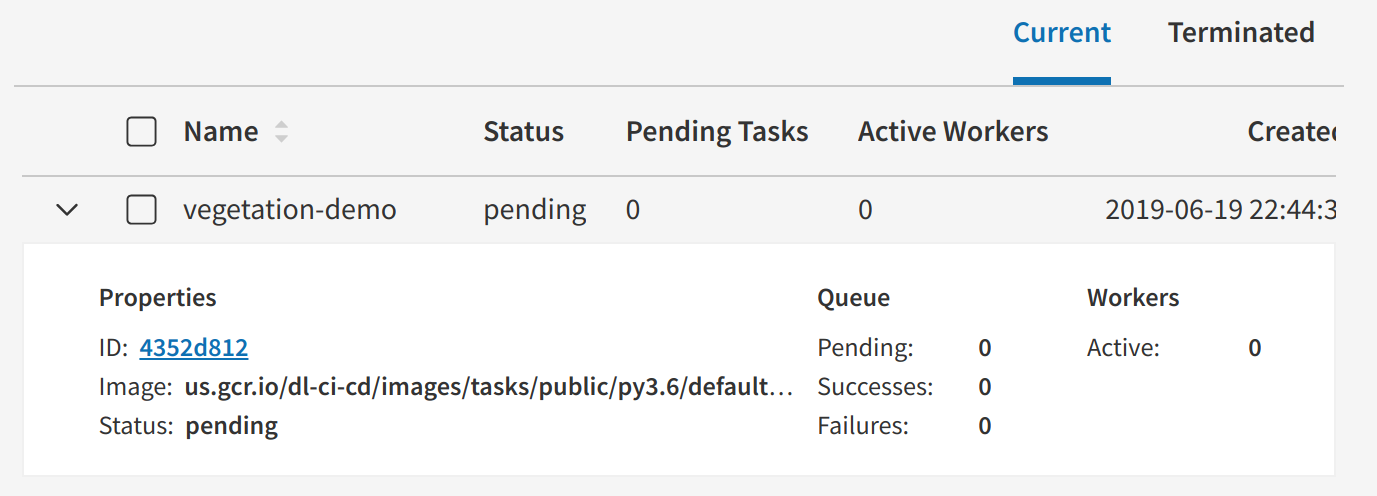

Once the status changes from *pending* to *running* the Task group will start scaling your computation.

## Launching Tasks
____________

We have now instantiated a Task group. It returned a [CloudFunction](https://docs.descarteslabs.com/descarteslabs/client/services/tasks/readme.html#descarteslabs.client.services.tasks.CloudFunction) which can be used to send our requests to the Task group. Tasks are then put into a queue and scheduled for work. 

In [ ]:
async_func

Say we wanted to run this model over more crop fields. We would define a region of interest which could be as large as we would like. 

In [ ]:
aoi = {"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-99.32275771466082,39.510715877324],[-99.17530059814455,39.510715877324],[-99.17530059814455,39.537992699478735],[-99.32275771466082,39.537992699478735],[-99.32275771466082,39.510715877324]]]}, "properties":{}}

In [ ]:
from ipyleaflet import Map, GeoJSON, basemaps
m = Map(center=(39.52371, -99.25272), zoom=13, basemap=basemaps.Esri.WorldImagery)
m.add_layer(GeoJSON(data=aoi))
m

Once we have a region of interest, [scenes.DLTile.from_shape](https://docs.descarteslabs.com/descarteslabs/scenes/docs/geocontext.html#descarteslabs.scenes.geocontext.DLTile.from_shape) will let us break that region up into chucks which can be analyzed in parallel. 

In [ ]:
tiles = dl.scenes.DLTile.from_shape(aoi, resolution=1, tilesize=512, pad=0)

In [ ]:
len(tiles)

There are 182 tiles in this region of interest. We can easily launch our tasks by iterating over the tiles and calling the CloudFunction object as if we were calling a local function.

In [ ]:
for tile in tiles:
    async_func(tile.key)

## Getting Results
________________________

We can check the status of each task using the [Monitor](https://monitor.descarteslabs.com/) page. We also can get the results back from the tasks via the client. We can retreive the id for a Task group using [get_group_by_name](https://docs.descarteslabs.com/descarteslabs/client/services/tasks/readme.html#descarteslabs.client.services.tasks.Tasks.get_group_by_name) (wait for the Task group to start before running this).

In [ ]:
group_info = tasks.get_group_by_name('vegetation-demo')
group_info.id

We can retreive metadata about __finished__ tasks by using [get_task_results](https://docs.descarteslabs.com/descarteslabs/client/services/tasks/readme.html#descarteslabs.client.services.tasks.Tasks.get_group_by_name).

In [ ]:
results = tasks.get_task_results(group_info.id, include=['arguments', 'result_url'])

In [ ]:
results['results']

Let's load the information and result for each task.

In [ ]:
import json
import requests

result_dict = {}
for result in results['results']:
    if result.status == 'SUCCESS':
        r = json.loads(requests.get(result.result_url).text)
        args_dict = json.loads(result.arguments)
        key = args_dict['args'][0]
        result_dict[key] = r

Now let's look at the vegetation values for a few of our tiles.

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, key in enumerate(result_dict):
    im = get_image(key)
    p = result_dict[key]
    ax[i].imshow(np.moveaxis(im[0:3], 0, -1))
    ax[i].set_title(f'Vegetation percentage: {round(p * 100)}%')
    
    if i >= 2:
        break

## Cleaning Up
____________

Because Tasks scale down when not in use, there is no cost reason to delete a Task Group. Tasks can be put in a terminated state which removes them from the Monitor view. New jobs cannot be submitted to terminated groups.

In [ ]:
tasks.delete_group_by_id(group_info.id)

## Advanced Tasks
______________________________

In the previous sections we deployed a simple model in Tasks. For more advanced Tasks usage, see the [Advanced Tasks section of the Tasks Guide](https://docs.descarteslabs.com/guides/tasks.html#advanced-tasks-usage)

## Wrap Up
_______________

We have deployed a simple model of crop coverage over a region of interest with Tasks. In the process we have:

* Used [tasks.create_function](https://docs.descarteslabs.com/descarteslabs/client/services/tasks/readme.html#descarteslabs.client.services.tasks.Tasks.create_function) to create a task group.

* Tile regions of interest with [scenes.DLTile](https://docs.descarteslabs.com/descarteslabs/scenes/docs/geocontext.html#descarteslabs.scenes.geocontext.DLTile).

* Called async functions to deploy tasks.

* Retreive task groups using [tasks.get_group_by_name](https://docs.descarteslabs.com/descarteslabs/scenes/docs/geocontext.html#descarteslabs.scenes.geocontext.DLTile).

* Get results back using [tasks.get_task_results](https://docs.descarteslabs.com/descarteslabs/client/services/tasks/readme.html#descarteslabs.client.services.tasks.Tasks.get_task_results).

* Terminate a Task group with [tasks.delete_group_by_id](https://docs.descarteslabs.com/descarteslabs/client/services/tasks/readme.html#descarteslabs.client.services.tasks.Tasks.delete_group_by_id)


# Resources
_____________

[1] [Tasks Documentation](https://docs.descarteslabs.com/descarteslabs/client/services/tasks/readme.html)

[2] [Tasks Guide](https://docs.descarteslabs.com/guides/tasks.html)